# Predicting AirBnB prices using Stacking Regression Models

Recommending AirBnB prices for listings
One of my course projects for my eCornell graduate certificate in Applied Machine Learning and AI was to build and compare models using Scikit Learn to recommend what an AirBnB host should charge for their place in NYC based on historical data.

A preprocessed dataset covering about 28,000 AirBnB listings was provided from Kaggle and covered 50 features about each listing, such as number of bedrooms/bathrooms/beds, review history, availability history, neighborhood, and more. Many of the features had already been normalized and standardized.

This specific eCornell course was focused on comparing and optimizing ensemble models, which are linear models combining multiple disparate linear models such as Linear Regression, Decision Trees, Random Forests, and Gradient Boosted Decision Trees. Ensemble models are great at combining the strengths of different algorithms to increase performance, but come at the cost of decreased explainability and increased training time.

First, I trained each of the individual models and optimized their hyperparameters using a grid search. The label column, price, had been normalized and I was interested in the absolute fit of linear regressors, so I chose the primary performance metric as Root Mean Squared Error (RSME). R2 was used as a secondary metric since it measures relative fit.

Amongst the individual regressors, Random Forest outperformed the other models with the lowest RSME (0.6302) and highest R2 (0.6237), but had the longest training time.

Second, I fit a series of stacking (ensemble) models that combined all four of the independent models and minimized the RSME using a grid search on each individual model’s hyperparameters. I tried a few rounds of different hyperparameter combinations to ensure I was locating a minimum. Fitting 1,000 models on my Macbook Air would take a while, so I migrated my Jupyter notebook to a paid instance on LambdaLabs. LambaLabs’s gpu_1x_a10 instance has 30 CPU cores, 24 GB RAM, and an NVIDIA A10 for $0.75 per hour. SciKit Learn can't leverage GPUs, but it was able to max out all 30 CPU cores on the instance. I grew frustrated with scikit-learn’s limitations and started migrating my project to XGBoost- the standard for linear models at many companies.

Finally, the performance of the optimized individual and ensemble models was visualized and compared.

The stacking model had the highest performance since it had the lowest RSME. The RSME of 0.62 on a scale of -1 to 6, or about 9% of the total range, is acceptable but could use improvement. More time could be spent further optimizing the hyperparameter values, but training times were significantly increasing with only 0.1% performance improvement. The optimal ensemble model's R2 value was 0.64.

The second highest performing model, the Random Forest, took 91% less time to train and was close in performance with an RSME of 0.6303 and R2 of 0.624. The Random Forest model would probably be a fine substitute since it required less time to train.

As the ground truth price increased, so did the error. The model performs well at predicting the prices for AirBnB units in almost the whole price range, but underestimates the price for the top 4% AirBnB units.

Future work ideas:

Hyperparameter tuning & Model Selection:
* Try out a RandomSelectionCV instead of a GridSearchCV
* Randomize the feature subset selection
* Remove some of the lower performing models like LinearRegression from the stacking model
* Vary and optimize individual model's hyperparameters that haven't been optimized yet, such as 
    DecisionTreeRegressor: max_features
    RandomForestRegressor: criterion, max_leaf_nodes, min_samples_split
    GradientBoostingRegressor: criterion, learning_rate, loss, max_depth, max_features
    LinearRegression: none really
* Investigate additional cross validation values- try 2 and 4 since it seemed to peak at 3 when given 1,3,5
* Try different methods of combining the stacked models, aka final_estimator

Feature engineering:
* Resample the most expensive AirBnB listings to give them more representation to improve model performance at the higher end of the price range
* Investigate dropping features that have low correlation with the label (price).
* Investigate dropping features that have high correlation with other features
* Investigate winsorizing additional features to reduce outliers


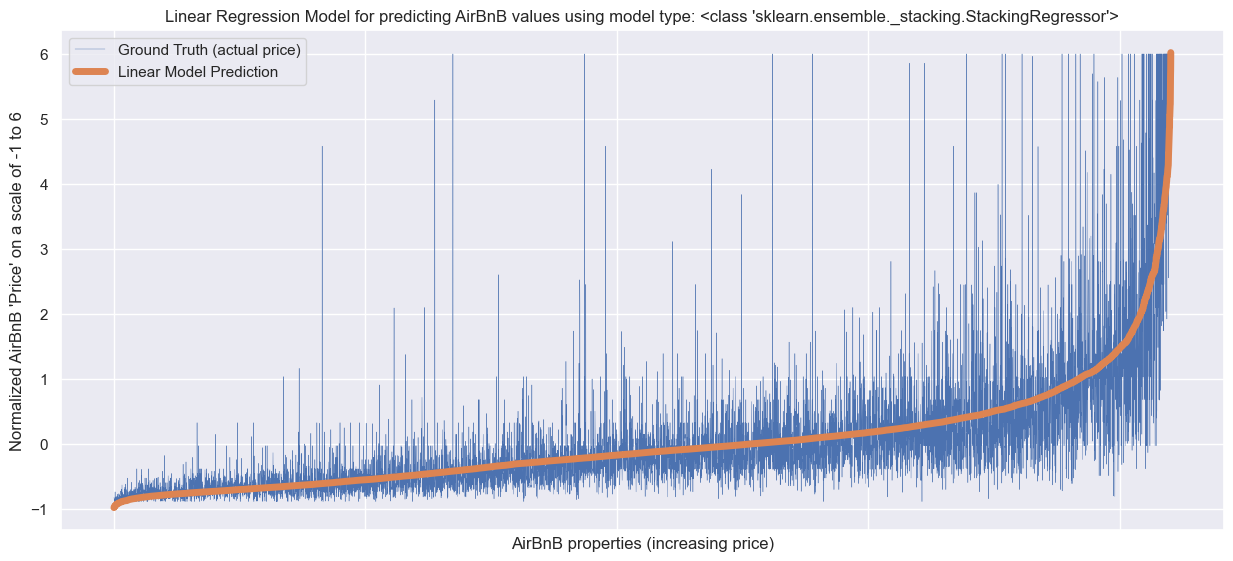

In [1]:
# Virtual Environment creation and installing dependencies
# !virtualenv .venv
# !source .venv/bin/activate
#%pip install --upgrade pip
#%pip install -r requirements.txt
# %pip install --upgrade bottleneck pandas scikit-learn scipy numpy matplotlib pyarrow seaborn numexpr

In [2]:
import os
import socket
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import pyarrow as pa
import pyarrow.parquet as pq

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")

In [3]:
# Optional performance enhancements, don't always work in Lambda Labs instances
# %load_ext Cython
# import numba
# numba.set_num_threads(4)

### Load the Data and split it into Training and Test Sets

In [4]:
df = pd.read_csv(filename, header=0,
                  dtype_backend='pyarrow',
                  engine='pyarrow')

# in this project, the label (output) column being studied is the price.
y = df['price']
X = df.drop(columns = 'price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1234)

## Fit and Evaluate Individual Regression Models

### Individual Model: Linear Regression

<!-- Training times on Macbook Pro:
* 40.9 ms ± 20.2 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
* 33.7 ms ± 8.85 ms per loop (mean ± std. dev. of 500 runs, 1 loop each) with n_jobs=-1
* 180 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with n_jobs=-1 and pyarrow backend -->

[comment]: <> (Performance:)
 [comment]: <> (* Root Mean Squared Error: 0.7449)
 [comment]: <> (* R2: 0.4744)

In [5]:
lr_model = LinearRegression(n_jobs=-1)

# train the model and record the training time
lr_time_start = time.time()
lr_model.fit(X_train, y_train)
lr_time_stop = time.time()
lr_time = lr_time_stop - lr_time_start

# Make predictions on the test data
y_lr_pred = lr_model.predict(X_test)

# Compute the RMSE and R2
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print(f'[LR] Root Mean Squared Error: {round(lr_rmse, 4)}')
print(f'[LR] R2: {round(lr_r2, 4)}')
print(f'[LR] Fit time: {round(lr_time, 3)} sec')

[LR] Root Mean Squared Error: 0.7446
[LR] R2: 0.4748
[LR] Fit time: 0.024 sec


### Individual Model: Decision Tree 
In a previous project, I ran a grid search to find the best model hyperparameters for the decision tree. 
The best values were: `max_depth=8`, and `min_samples_leaf = 50`.

<!-- Training times on Macbook Pro: 
 * 117 ms ± 12.1 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
 * 166 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with pyarrow backend -->

[comment]: <> (Performance:)
[comment]: <> ( * Root Mean Squared Error: 0.7351)
 [comment]: <> (* R2: 0.4882)

In [6]:
# parallel processing (n_jobs) is not available for DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=50)

# fit the model and record the training time
dt_time_start = time.time()
dt_model.fit(X_train, y_train)
dt_time_stop = time.time()
dt_time = dt_time_stop - dt_time_start

# make predictions on the test data.
y_dt_pred = dt_model.predict(X_test)

# Compute the RMSE and R2
dt_rmse = np.sqrt(mean_squared_error(y_test, y_dt_pred))
dt_r2 = r2_score(y_test, y_dt_pred)

print(f'[DT] Root Mean Squared Error: {round(dt_rmse, 4)}')
print(f'[DT] R2: {round(dt_r2, 4)}')
print(f'[DT] Fit time: {round(dt_time, 3)} sec')

[DT] Root Mean Squared Error: 0.7354
[DT] R2: 0.4878
[DT] Fit time: 0.188 sec


### Individual Model: Gradient Boosted Decision Tree 

In a previous project, I ran a grid search to find the best model hyperparameters for the gradient boosted decision tree.
The best values were: `max_depth=2`, and `n_estimators = 300`.

 <!-- Training times on Macbook Pro: 
  * 9.55 s ± 348 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
  * 9.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with pyarrow backend -->

[comment]: <> (Performance)
[comment]: <> ( * Root Mean Squared Error: 0.6606)
[comment]: <> ( * R2: 0.5864)

In [7]:
# parallel processing (n_jobs) is not available for GradientBoostingRegressor
gbdt_model = GradientBoostingRegressor(max_depth=2, n_estimators=300)

# fit the model and record the training time
gbdt_time_start = time.time()
gbdt_model.fit(X_train, y_train)
gbdt_time_stop = time.time()
gbdt_time = gbdt_time_stop - gbdt_time_start

# Make predictions on the test data
y_gbdt_pred = gbdt_model.predict(X_test)

# Compute the RMSE and R2
gbdt_rmse = np.sqrt(mean_squared_error(y_test, y_gbdt_pred))
gbdt_r2   = r2_score(y_test, y_gbdt_pred)

print(f'[GBDT] Root Mean Squared Error: {round(gbdt_rmse, 4)}')
print(f'[GBDT] R2: {round(gbdt_r2, 4)}')
print(f'[LR] Fit time: {round(gbdt_time, 3)} sec')

[GBDT] Root Mean Squared Error: 0.6607
[GBDT] R2: 0.5866
[LR] Fit time: 6.713 sec


### Individual Model: Random Forest

<!-- Training times on Macbook Pro:
 * 1min 13s ± 1.27 s per loop (mean ± std. dev. of 5 runs, 1 loop each)
 * 20.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=-1 with default backend
 * 14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=-1 and pyarrow backend -->
 
[comment]: <> (Performance:)
[comment]: <> ( * Root Mean Squared Error: 0.6289)
[comment]: <> ( * R2: 0.6254)

In [8]:
rf_model = RandomForestRegressor(max_depth=32, n_estimators=300, n_jobs=-1)

# fit the model and record the training time
rf_time_start = time.time()
rf_model.fit(X_train, y_train)
rf_time_stop = time.time()
rf_time = rf_time_stop - rf_time_start

# make predictions on the test data
y_rf_pred = rf_model.predict(X_test)

# Compute RMSE and R2
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
rf_r2   = r2_score(y_test, y_rf_pred)

print(f'[RF] Root Mean Squared Error: {round(rf_rmse, 4)}')
print(f'[RF] R2: {round(rf_r2, 4)}')
print(f'[RF] Fit time: {round(rf_time, 3)} sec')

[RF] Root Mean Squared Error: 0.6286
[RF] R2: 0.6258
[RF] Fit time: 7.084 sec


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

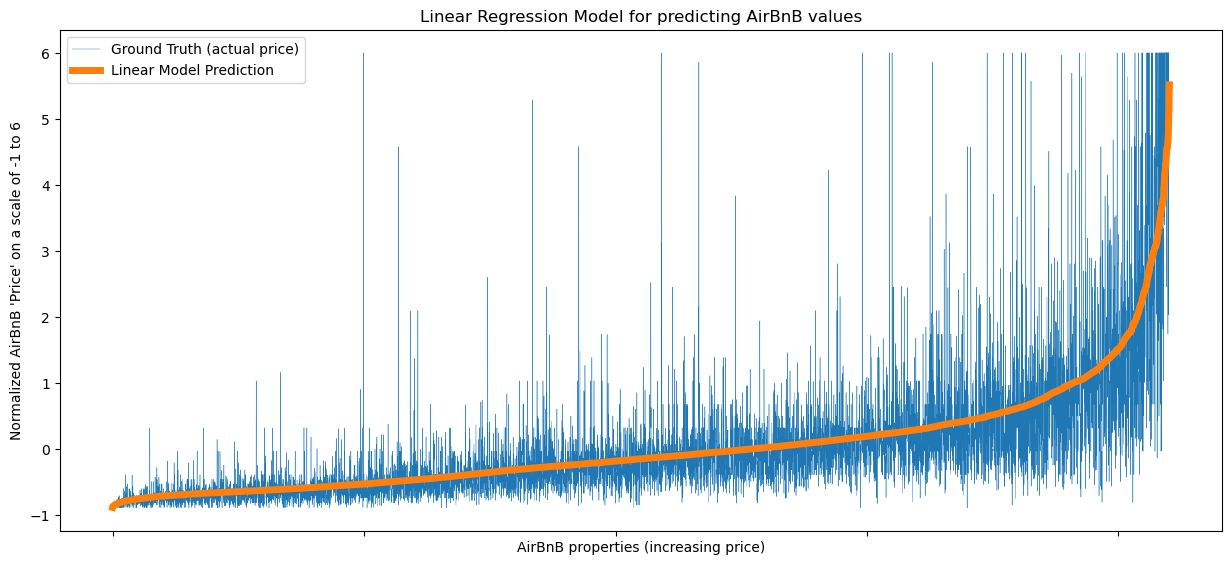

In [9]:
# Plot the predicted price vs the real price for the test set
x_values  = np.arange(len(y_test))
ground_truth = y_test
predicted = y_rf_pred
df_tmp = pd.DataFrame({'ground_truth': ground_truth,
                        'predicted': predicted})
df_tmp.sort_values('predicted', inplace=True)

fig = plt.figure(figsize=(15, 6.5))
ax = fig.add_subplot(111)
sns.lineplot(x=x_values, y=df_tmp['ground_truth'], linewidth=0.3, 
                legend="full", label='Ground Truth (actual price)')
sns.lineplot(x=x_values, y=df_tmp['predicted'], linewidth=5, 
                legend="full", label='Linear Model Prediction')

plt.title(f'Linear Regression Model for predicting AirBnB values')
plt.xlabel("AirBnB properties (increasing price)")
plt.ylabel("Normalized AirBnB 'Price' on a scale of -1 to 6")
plt.xticks(visible=False)
plt.show()    

In [10]:
# fig = plt.figure(figsize=(15, 6.5))
# ax = fig.add_subplot(111)
# # https://seaborn.pydata.org/generated/seaborn.lineplot.html
# sns.lineplot(x=df_plot['ground_truth price'], y=df_plot['ground_truth price'], linewidth=0.3, 
#                 legend="full", label='Ground Truth (actual price)') # must be last

# sns.lineplot(x=df_plot['ground_truth price'], y=df_plot['predicted price'], linewidth=0.3, 
#                 legend="full", label='Ground Truth (actual price)') # must be last

# #sns.lineplot(x=x_values, y=df_tmp['predicted'], linewidth=5, 
# #                legend="full", label='Linear Model Prediction')


In [11]:
# df_plot2 = df_plot.sort_values(by="predicted price")

# fig = plt.figure(figsize=(15, 6.5))
# ax = fig.add_subplot(111)

# sns.lineplot(x=df_plot2['predicted price'], y=df_plot2['predicted price'], linewidth=0.3, 
#                 legend="full", label='Predicted')
# sns.lineplot(x=df_plot2['predicted price'], y=df_plot2['ground_truth price'], linewidth=0.3, 
#                 legend="full", label='Ground Truth')


## Combining the individual models into a single Stacking Model

Running a variety of hyperparameter combinations to find which one has the lowest RSME.

In [12]:
# estimators = [
#     ("LR",   LinearRegression()),
#     ("DT",   DecisionTreeRegressor()),
#     ("RF",   RandomForestRegressor()),
#     ("GBDT", GradientBoostingRegressor()),
#     ]

# stacking_model = StackingRegressor(estimators=estimators, cv=5, passthrough=False)

# params = {
#     "DT__max_depth":        [4, 8, 16],                    
#     "GBDT__max_depth":      [4, 8, 16],                    
#     "DT__min_samples_leaf": [50, 100, 250],
#     "RF__max_depth":        [4, 8, 16],
#     "RF__n_estimators":     [100, 200],             
#     "GBDT__n_estimators":   [100, 200],             
# }

# # scoring = {"NRSME": "neg_root_mean_squared_error", "R2": make_scorer(r2_score)}
# # stack_grid = GridSearchCV(stacking_model, params, cv=3, verbose=4, scoring=scoring, refit='NRSME', return_train_score=True, n_jobs=-1)
# stack_grid = GridSearchCV(stacking_model, params, cv=3, verbose=4, scoring='neg_root_mean_squared_error', n_jobs=-1)
# stack_grid.fit(X_train, y_train)

## Evaluating the optimal Stacking Model

 <!-- * 2min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) -->
 * Root Mean Squared Error: 0.6206763671097633
 * R2: 0.6351118454144045

In [13]:
estimators_best = [("DT", DecisionTreeRegressor(max_depth=8)),
                    ("RF", RandomForestRegressor()),
                    ("GBDT", GradientBoostingRegressor(n_estimators=100)),
                    ("LR", LinearRegression())
                    ]

# stacking_model = StackingRegressor(estimators=estimators_best, cv=3, passthrough=False)
stacking_best_model = StackingRegressor(estimators_best)
# %timeit -n1 -r1 stacking_best_model.fit(X_train, y_train)

stacking_time_start = time.time()
stacking_best_model.fit(X_train, y_train)
stacking_time_stop = time.time()
stacking_time = stacking_time_stop - stacking_time_start

stacking_best_pred = stacking_best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, stacking_best_pred))
r2 = r2_score(y_test, stacking_best_pred)

print('[Stacking] Root Mean Squared Error: {0}'.format(rmse))
print('[Stacking] R2: {0}'.format(r2))
print(f'[Stacking] Fit time: {round(stacking_time, 3)} sec')

[Stacking] Root Mean Squared Error: 0.6211676336413512
[Stacking] R2: 0.6345339974766173
[Stacking] Fit time: 87.667 sec


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Axes: xlabel='price', ylabel='price'>

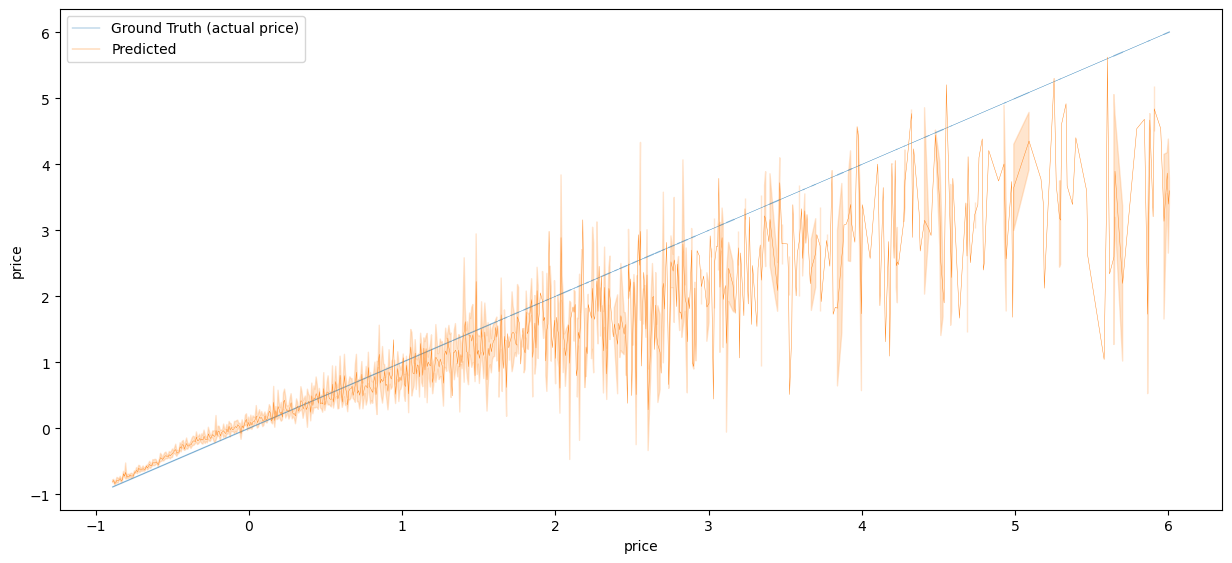

In [14]:
# whole entire dataset plot
y_whole_dataset = stacking_best_model.predict(X)

fig = plt.figure(figsize=(15, 6.5))
ax = fig.add_subplot(111)

sns.lineplot(x=y, y=y, linewidth=0.3, 
                legend="full", label='Ground Truth (actual price)')

sns.lineplot(x=y, y=y_whole_dataset, linewidth=0.3, 
                legend="full", label='Predicted')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Axes: xlabel='ground_truth price', ylabel='ground_truth price'>

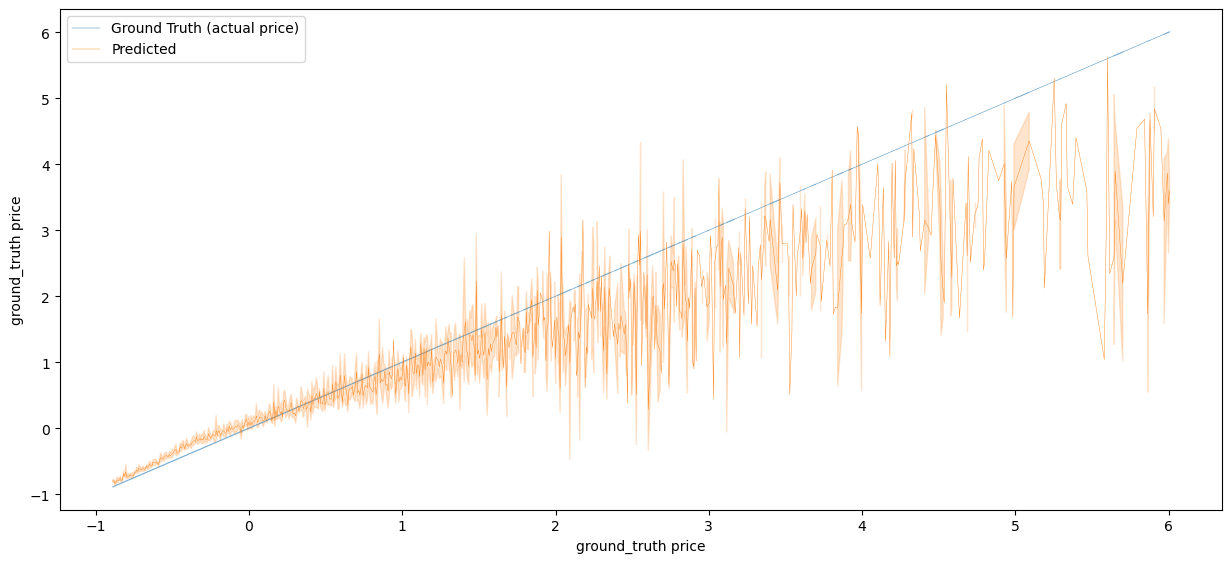

In [15]:
df_plot4 = pd.DataFrame({'ground_truth price': y, 'predicted price': y_whole_dataset})

df_plot4.sort_values(by="ground_truth price", inplace=True)

fig = plt.figure(figsize=(15, 6.5))
ax = fig.add_subplot(111)

sns.lineplot(x=df_plot4['ground_truth price'], y=df_plot4['ground_truth price'], linewidth=0.3, 
                legend="full", label='Ground Truth (actual price)')

sns.lineplot(x=df_plot4['ground_truth price'], y=df_plot4['predicted price'], linewidth=0.3, 
                legend="full", label='Predicted')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ground_truth price', ylabel='error'>

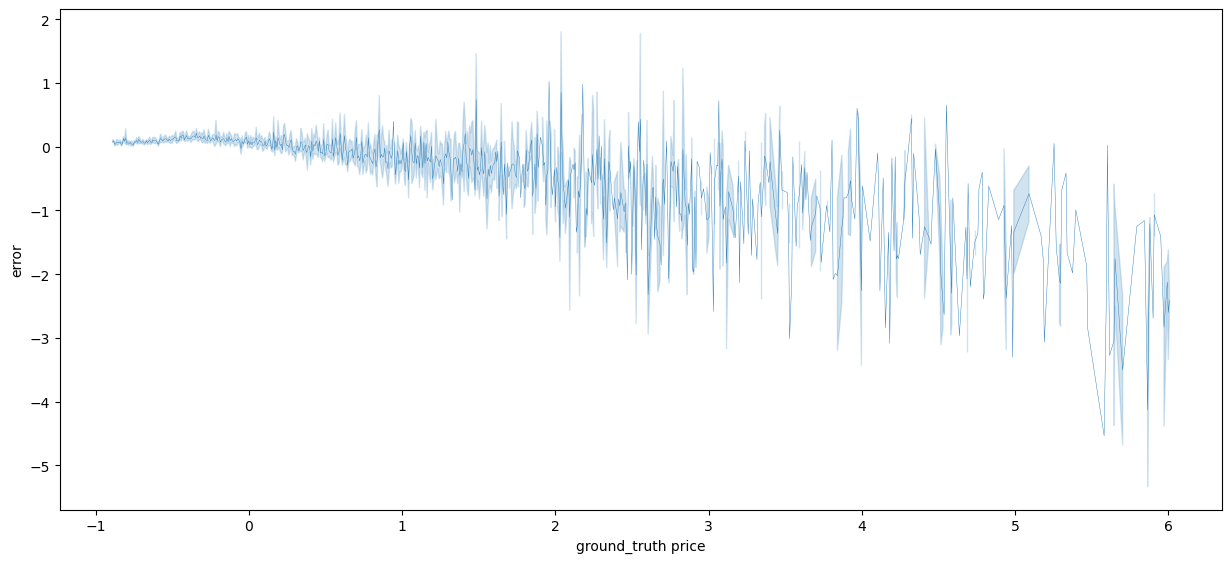

In [16]:
df_plot4['error'] = df_plot4['predicted price'] - df_plot4['ground_truth price']

fig = plt.figure(figsize=(15, 6.5))
ax = fig.add_subplot(111)

sns.lineplot(x=df_plot4['ground_truth price'], y=df_plot4['error'], linewidth=0.3, 
                legend="full")

## Comparing Individual Model Performances and the Stacked Ensemble Model

Visualizing the RMSE and R2 score for the stacked ensemble model and each regressor.

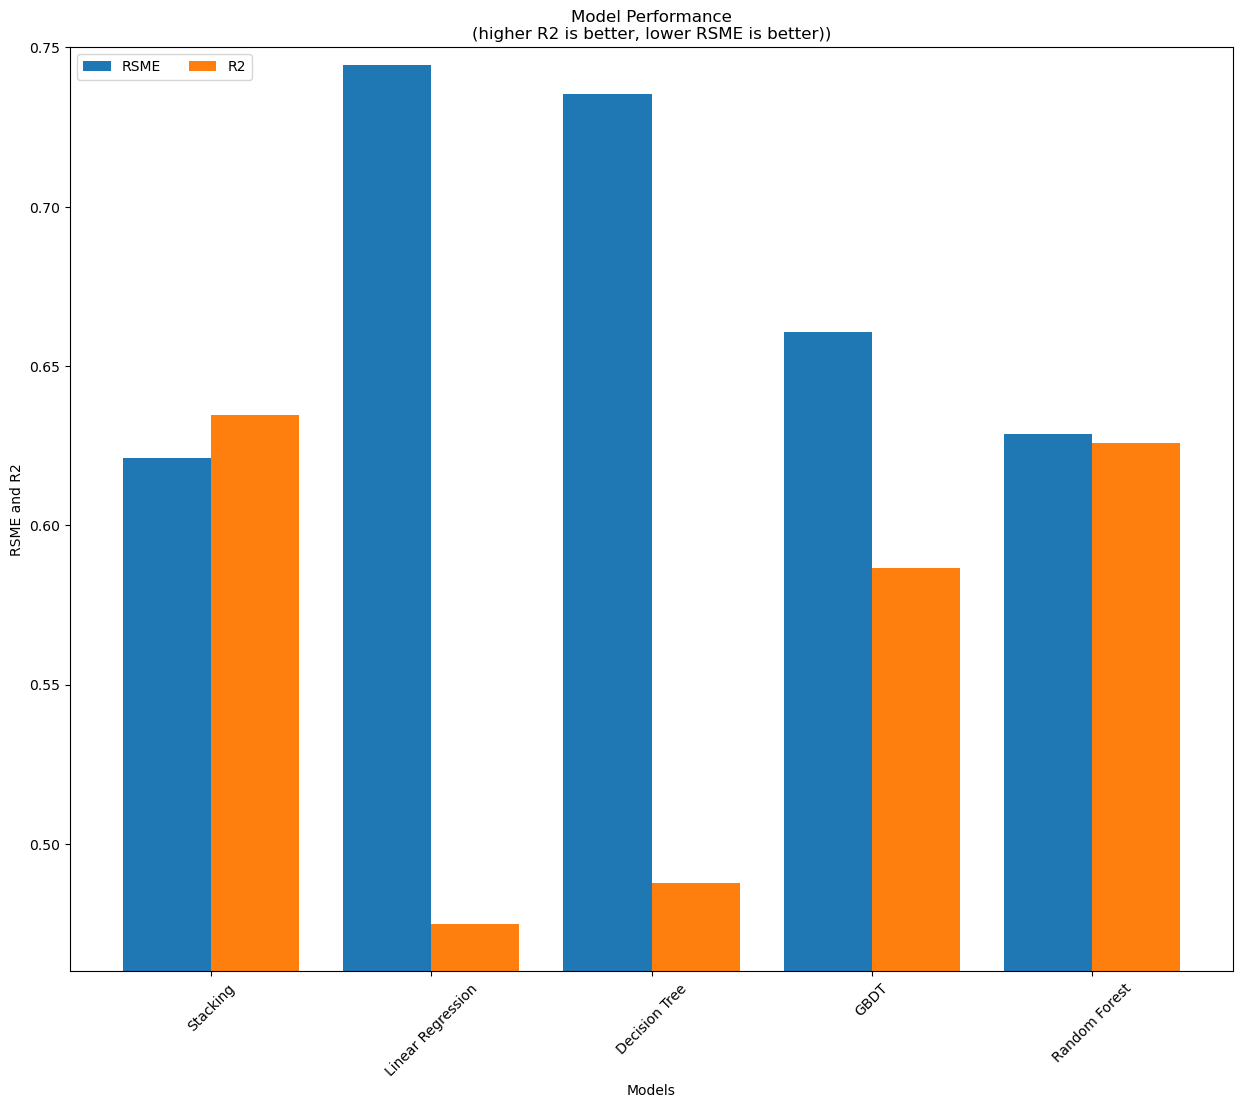

In [17]:
# create lists of the results from previous runs
alg_names    = ['Stacking', 'Linear Regression', 'Decision Tree', 'GBDT', 'Random Forest']
# training runtimes as manually recorded from above
#runtimes_in_sec = [163, 0.180, 0.166, 9.31, 14.9]            # Macbook Pro 2017, with n_jobs=-1 and pyarrow backend
runtimes_in_sec = [stacking_time, lr_time, dt_time, gbdt_time, rf_time] 

RMSE_Results = [rmse, lr_rmse, dt_rmse, gbdt_rmse, rf_rmse]
R2_Results   = [r2, lr_r2, dt_r2, gbdt_r2, rf_r2]

rg = np.arange(5)
width = 0.35

# Create bar plot with RMSE results
fig = plt.figure(figsize=(15,12))
plt.bar(rg - 0.2, RMSE_Results, 0.4, label = 'RSME')

# Create bar plot with R2 results
plt.bar(rg + 0.2, R2_Results,   0.4, label = 'R2') 

# label each model's name
plt.xticks(rg, alg_names, rotation=45)

# Label the x (Models) and y axis (RSME and R2) of the plot
localhostname = socket.gethostname()
plt.xlabel("Models")
plt.ylabel("RSME and R2")
#plt.ylim([0,1])
plt.ylim([0.46, 0.75])        # zoom in
plt.title(f"Model Performance\n(higher R2 is better, lower RSME is better))")
plt.legend(loc='upper left', ncol=2)
plt.show()

# Training time Analysis

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


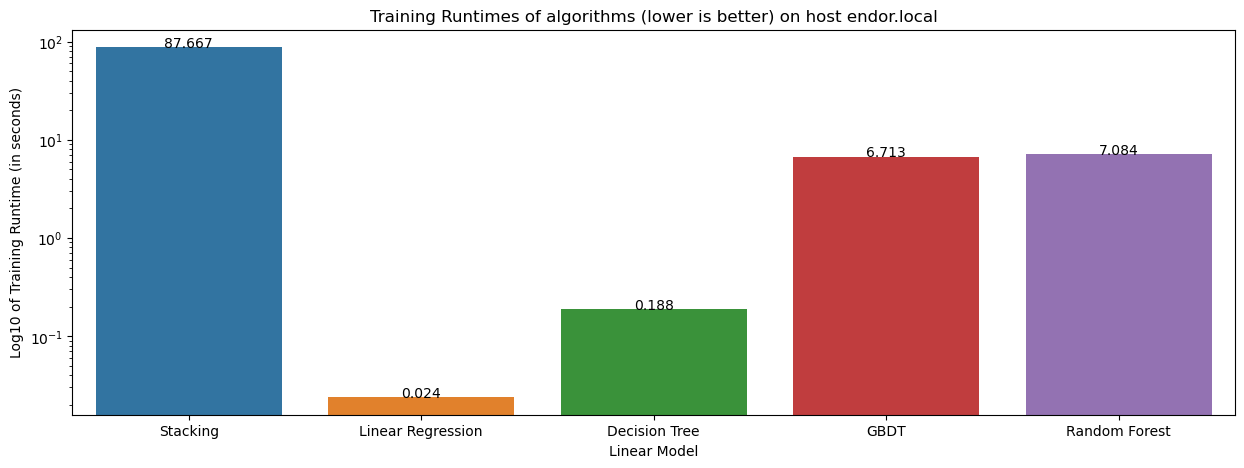

In [18]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x=alg_names, y=runtimes_in_sec)
addlabels(alg_names, np.round(runtimes_in_sec,3))

plt.title(f'Training Runtimes of algorithms (lower is better) on host {localhostname}')

g = ax.set_xlabel('Linear Model')
g = ax.set_ylabel('Log10 of Training Runtime (in seconds)')

ax.set_yscale("log")